In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

In [18]:
train_dir = "/kaggle/input/coffee-bean-tanvir/train"
test_dir = "/kaggle/input/coffee-bean-tanvir/test"

# Training Data Generator (with validation split)
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 20% of training data for validation
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'    # <-- this is the training subset
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # <-- this is the validation subset
)

# ======================
# Test Data Generator (final evaluation)
# ======================
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Quick sanity check
# ======================
print("Train classes mapping:", train_gen.class_indices)
print("Validation classes mapping:", val_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Validation classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [19]:
def se_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]
    
    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(feature_map)
    se = layers.Reshape((1,1,channel))(se)
    
    # Excitation: Two FC layers
    se = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)(se)
    se = layers.Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)(se)
    
    # Scale feature map
    x = layers.Multiply()([feature_map, se])
    return x

In [20]:
def build_se_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Conv Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Global Average Pooling (feature output)
    gap = layers.GlobalAveragePooling2D()(x)

    # Dense head for training only
    dense = layers.Dense(256, activation='relu')(gap)
    dense = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    model = models.Model(inputs, outputs)
    return model

In [21]:
num_classes = train_gen.num_classes
se_model = build_se_cnn(input_shape=(128,128,3), num_classes=num_classes)

se_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = se_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - accuracy: 0.2322 - loss: 1.3875 - val_accuracy: 0.2625 - val_loss: 1.3807
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.2415 - loss: 1.3677 - val_accuracy: 0.2958 - val_loss: 1.2222
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.4940 - loss: 1.0550 - val_accuracy: 0.7250 - val_loss: 0.7381
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.6528 - loss: 0.7053 - val_accuracy: 0.7167 - val_loss: 0.6858
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.7082 - loss: 0.6190 - val_accuracy: 0.7375 - val_loss: 0.6026
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.7277 - loss: 0.5716 - val_accuracy: 0.8083 - val_loss: 0.5344
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.8337 - loss: 0.4462 - val_accuracy: 0.7917 - val_loss: 0.4192
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.7963 - loss: 0.4671 - val_accuracy: 0

In [22]:
feature_extractor = models.Model(
    inputs=se_model.input,
    outputs=se_model.layers[-4].output   # GAP output before Dense
)
def extract_features(model, generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels
X_train, y_train = extract_features(feature_extractor, train_gen)
X_val, y_val     = extract_features(feature_extractor, val_gen)
X_test, y_test   = extract_features(feature_extractor, test_gen)

In [23]:
# Apply StandardScaler to the extracted features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5) # You can adjust n_neighbors
knn.fit(X_train_scaled, y_train)


# Evaluate the KNN classifier on validation data
y_val_pred_knn = knn.predict(X_val_scaled)
print("Validation Accuracy (KNN):", accuracy_score(y_val, y_val_pred_knn))

# Evaluate the KNN classifier on test data
y_test_pred_knn = knn.predict(X_test_scaled)
print("Test Accuracy (KNN):", accuracy_score(y_test, y_test_pred_knn))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred_knn, target_names=list(train_gen.class_indices.keys())))

Validation Accuracy (KNN): 0.975
Test Accuracy (KNN): 0.96
              precision    recall  f1-score   support

        Dark       0.94      0.97      0.96       100
       Green       1.00      0.98      0.99       100
       Light       0.98      0.95      0.96       100
      Medium       0.92      0.94      0.93       100

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



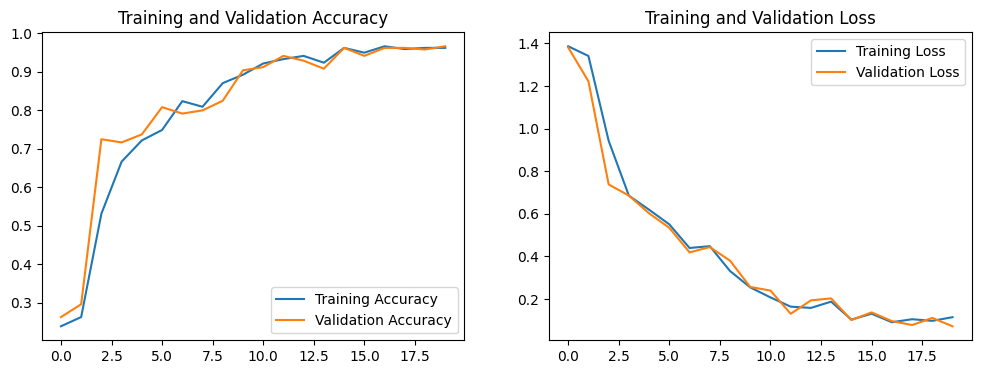

In [25]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy: 0.96
Precision: 0.9606744108913708
Recall: 0.96
F1-score: 0.9601810222281512
Confusion Matrix:
 [[97  0  0  3]
 [ 0 98  2  0]
 [ 0  0 95  5]
 [ 6  0  0 94]]


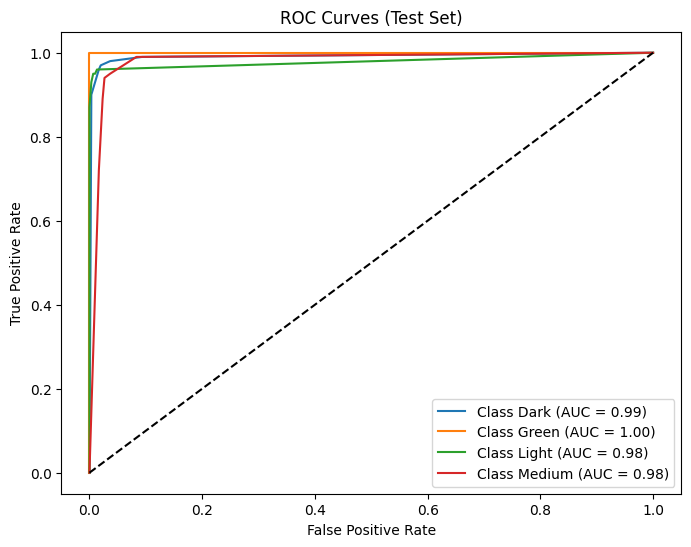

Test AUC: 0.9879875


In [27]:
# ---- Predictions ----
y_test_pred_knn = knn.predict(X_test_scaled)
# For probability estimates, use predict_proba
y_test_proba_knn = knn.predict_proba(X_test_scaled)


# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test, y_test_pred_knn))
print("Precision:", precision_score(y_test, y_test_pred_knn, average='macro'))
print("Recall:", recall_score(y_test, y_test_pred_knn, average='macro'))
print("F1-score:", f1_score(y_test, y_test_pred_knn, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_knn))

# ---- ROC-AUC Curves ----
# Binarize labels for multi-class ROC
classes_present = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes_present)

# Only plot ROC if at least 2 classes are present
if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba_knn[:, i])
        plt.plot(fpr, tpr, label=f"Class {list(train_gen.class_indices.keys())[classes_present[i]]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    # Compute overall ROC-AUC
    print("Test AUC:", roc_auc_score(y_test_bin, y_test_proba_knn, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")